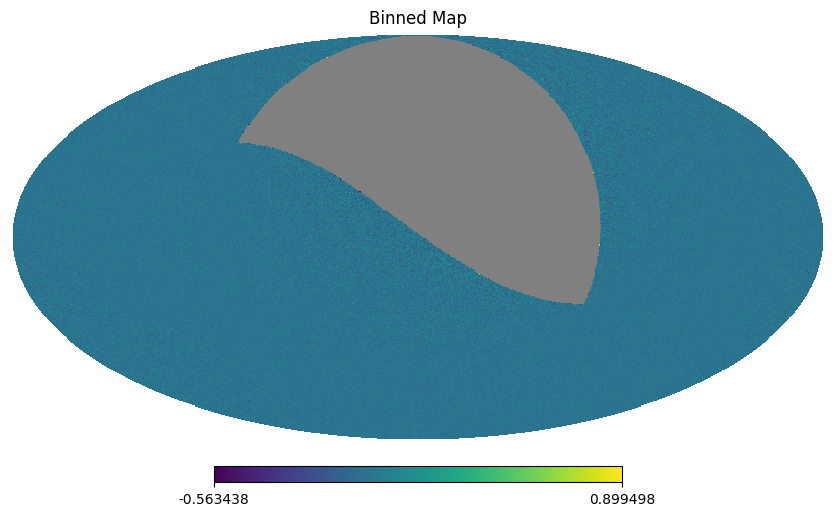

In [1]:
import numpy as np
import astropy.units as u
from numpy.random import MT19937, RandomState, SeedSequence
import healpy as hp

import litebird_sim as lbs


sim = lbs.Simulation(
    base_path="binner_output",
    start_time=0,
    duration_s=86400*90,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION) 
)


sim.set_scanning_strategy(
    scanning_strategy=lbs.SpinningScanningStrategy(
        spin_sun_angle_rad=np.deg2rad(30),
        spin_rate_hz=0.5 / 60,
        precession_rate_hz=1.0 / (4 * u.day).to("s").value,
    )
)


instr = lbs.InstrumentInfo(
    name="core",
    spin_boresight_angle_rad=np.deg2rad(65),
)

sim.set_instrument(instr)


sim.create_observations(
    detectors=[
        lbs.DetectorInfo(name="0A", sampling_rate_hz=10, net_ukrts=50),
        lbs.DetectorInfo(name="0B", sampling_rate_hz=10, quat=lbs.quat_rotation_z(np.pi/2), net_ukrts=50),
    ],
    tod_dtype=np.float64,
    n_blocks_time=lbs.MPI_COMM_WORLD.size,
    split_list_over_processes=False,
)


sim.prepare_pointings()


rs = RandomState(MT19937(SeedSequence(123456789)))

for curobs in sim.observations:
    curobs.tod *= 0.0
    curobs.tod += rs.randn(*curobs.tod.shape)

result = sim.make_binned_map(nside=128)
hp.mollview(result.binned_map[0], title="Binned Map")